# Triple Coincidence Analysis

In [1]:
#Include modules
import os
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from multiprocessing import Pool

In [2]:
# Read the files

# Parameters
run         = 'run1'
header      = ['EventID','TrackID','Particle','EnergyDeposited','XPosition','YPosition','ZPosition','LocalTime','Volume']
PROCESSES   = os.cpu_count()-1

# Find the files
foldername  = f'./data/{run}/output'
filenames   = os.listdir(foldername)

print(f'Found {len(filenames)} data files in {foldername}') 

# Execute with progressbar decorator
def execute_process(func):
    def inner(array):
        # Parallelize loading them
        with Pool(PROCESSES) as pool:
            output = list(tqdm(pool.imap(func, array),total=len(filenames)))
        return output

    return inner



# Function to load a single file
def loadfile(filename):
    return pd.read_csv(os.path.join(foldername,filename),skiprows=14,names=header)

# Read the files into a list
def get_files(filenames):

    # Parallelize loading themEnergyDeposited
    with Pool(PROCESSES) as pool:
        files = list(tqdm(pool.imap(loadfile, filenames),total=len(filenames)))
    return files

files = get_files(filenames)


Found 2048 data files in ./data/run1/output


  0%|          | 0/2048 [00:00<?, ?it/s]

In [3]:
def filter(x):
    check_cases = [['physPaddleTop'],['physPaddleBottom'],['physSiliconSubstrate','physSiliconOxide','physSiliconNitride']]
    return all([x['Volume'].isin(keys).any() for keys in check_cases])

def filter_file(file):
    data = file[file.groupby(['EventID','TrackID'])['TrackID'].transform('count')  >= 3]
    data = data[data.groupby(['EventID','TrackID'])['Volume'].transform('nunique') >= 3]
    return data.groupby(['EventID','TrackID']).filter(filter)

def get_triple_coincidences(files):
    with Pool(PROCESSES) as pool:
        events = list(tqdm(pool.imap(filter_file, files),total=len(files)))

    return pd.concat(events)

def get_muons(data):
    return data.loc[data['Particle'].str.contains('mu') & data['Volume'].str.contains('Silicon')]

def get_muon_events(files):
    with Pool(PROCESSES) as pool:
        events = list(tqdm(pool.imap(get_muons, files),total=len(files)))
    
    return pd.concat(events)

triple_events   = get_triple_coincidences(files)
events          = get_muon_events(files)

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

In [4]:
len(events.groupby(['EventID','TrackID']))/len(triple_events.groupby(['EventID','TrackID']))

5.31591263650546

In [5]:
energy_data = events.groupby(['EventID','TrackID'])['EnergyDeposited'].sum().reset_index()

Text(0, 0.5, 'Density')

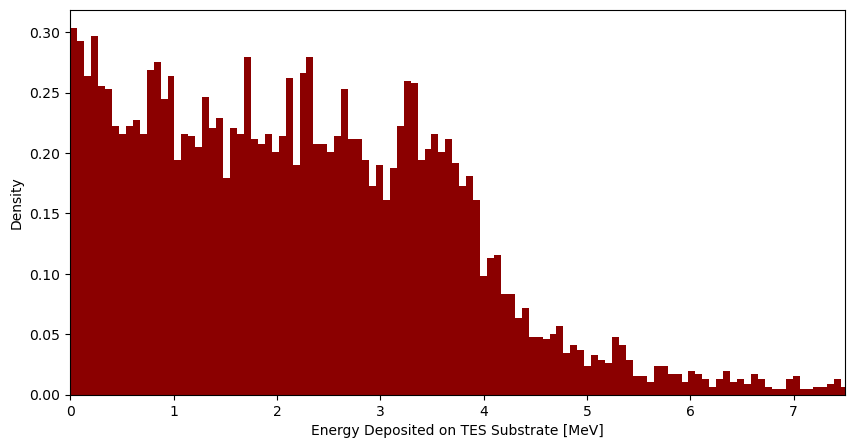

In [6]:
fig = plt.figure(figsize=(10,5))
ax  = fig.add_subplot(111)
ax.hist(energy_data.EnergyDeposited,bins=170,color = 'darkred',density=True);

ax.set_xlim(0,7.5)
ax.set_xlabel('Energy Deposited on TES Substrate [MeV]')
ax.set_ylabel('Density')